In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm



In [ ]:
#client 
import numpy as np

class client(object):
    def __init__(self,
                 index,
                 thorizon,
                 narms,
                 nclients,
                 palpha,
                 fp):
        self.T = thorizon
        self.id = index
        self.K = narms
        self.M = nclients
        self.alpha = palpha
        self.fp = fp
        
        self.p = 1
        self.local_set = set(np.arange(self.K))
        self.global_set = set(np.arange(self.K))
        self.local_mean = np.zeros(self.K)
        self.global_mean = np.zeros(self.K)
        self.mixed_mean = np.zeros(self.K)
        self.reward = np.zeros(self.K)
        
        self.pull = np.zeros(self.K)
        self.p_length = self.fp(self.p)
        self.Fp = 0
        
        self.fphase = 0
        self.gphase = 0
        
        self.F = -1
        self.l_exploration = False
        self.g_exploration = False
    
    def play(self, Mt):
        if self.fphase < np.ceil((1-self.alpha)*self.p_length)*len(self.global_set): #global exploration
#            print("loc", self.p)
            #play = list(self.global_set)[self.fphase%len(self.global_set)]
            play = list(self.global_set)[int(self.fphase//(np.ceil((1-self.alpha)*self.p_length)))]
            self.fphase += 1
            
        elif self.gphase < np.ceil(Mt*self.alpha*self.p_length)*len(self.local_set): #local exploration
#            print("glob", self.p)
            #play = list(self.local_set)[self.gphase%len(self.local_set)]
            play = list(self.local_set)[int(self.gphase//(np.ceil(Mt*self.alpha*self.p_length)))]
            self.gphase += 1
            
        else: #exploitation phase
            if self.l_exploration is True:
                play = self.F
            else:
                play = np.argmax(self.alpha*self.local_mean+(1-self.alpha)*self.global_mean)
            
        return play
    
    def reward_update(self,play,obs):
        self.reward[play] += obs
        self.pull[play] += 1
        
    def local_mean_update(self, Mt):
        #print('global',self.fphase,np.ceil((1-self.alpha)*self.p_length)*len(self.global_set))
        #print('local',self.gphase,np.ceil(self.M*self.alpha*self.p_length)*len(self.local_set))
        if self.g_exploration is False and self.fphase >= np.ceil((1-self.alpha)*self.p_length)*len(self.global_set) and self.gphase >= np.ceil(Mt*self.alpha*self.p_length)*len(self.local_set):
            self.local_mean = self.reward/self.pull
            #print("local_mean",self.local_mean, "phase", self.p)
            return True, self.local_mean
        else:
            return False, 0
        
    def global_mean_update(self,global_stat):
        self.global_mean = global_stat
        self.mixed_mean = self.alpha*self.local_mean+(1-self.alpha)*self.global_mean
        
    def local_set_update(self, Mt):
        Ep = set()
        self.Fp += self.p_length
        conf_bound = np.sqrt(np.log(self.T)/(Mt*self.Fp))
        for i in list(self.local_set):
            if self.mixed_mean[i]+conf_bound < max(self.mixed_mean-conf_bound):
                Ep.add(i)
        self.local_set = self.local_set-Ep
        
        if len(self.local_set) == 1 and self.l_exploration is False:
            self.l_exploration = True
            self.F = list(self.local_set)[0]
            #print("player", self.id,  " fixate",self.F)
            self.local_set = set()
        #print("player", self.id, " local-set:",self.local_set)    
        return self.local_set
        
        
    def global_set_update(self,global_set):
        self.global_set = global_set
        self.p +=1
        self.p_length = self.fp(self.p)
        #print("p-length",self.p_length)
        self.fphase = 0
        self.gphase = 0
        self.g_exploration = (len(self.global_set)==0)
        
            
            
    
            

In [ ]:
#server

import numpy as np

class server(object):
    def __init__(self,
                 narms,
                 nclients):
        self.M = nclients
        self.K = narms
        #self.Mt = npartclients
        
        self.local_means = np.zeros([self.M,self.K])
        self.global_means = np.zeros(self.K)
        self.global_set = set()
        self.p = 1
        self.c_local_stat = np.zeros(self.M)
        
    def local_mean_update(self,i,local_stat):
        self.local_means[i] = local_stat
        self.c_local_stat[i] = 1
        
    def global_mean_update(self,Mt, part_clients):
        self.global_set = set()
        if sum(self.c_local_stat) >= Mt:
            self.upd = np.array([means[a,:] for a in part_clients])
            self.global_means = np.sum(self.upd, axis=0)/Mt
            self.c_local_stat = np.zeros(self.M)
            return True, self.global_means
        else:
            return False, 0
        
    def local_set_update(self,i,local_set):
        self.global_set = self.global_set|local_set
    
    def global_set_update(self):
        return self.global_set

In [ ]:
#bandits
class PFEDUCB(object):
    def __init__(self,
                 fun_fp,
                 T,
                 means, # M*K
                 alpha,
                 prob,
                 reward='Gaussian'):
        self.M = means.shape[0]
        self.K = means.shape[1]
        self.reward_type = reward
        self.p = prob
        self.alpha = alpha
        self.T = T
        self.C = 1
        self.comm = 0
        #self.part_clients = [index for index, value in enumerate(list(np.random.binomial(1, , self.M))) if value == 1]###################
        #self.Mt = len(self.part_clients)


        
        self.clients = [
            client(index = i, thorizon = self.T, narms=self.K, nclients = self.M, palpha = self.alpha, fp=fun_fp) for i in range(self.M)
        ]
        self.server = server(narms=self.K, nclients = self.M)


    def simulate_single_step_rewards(self):
        if self.reward_type == 'Bernoulli':
            return np.random.binomial(1, self.local_means)
        return np.random.normal(self.local_means, 1)

    def simulate_single_step(self, plays):

        local_rews = self.simulate_single_step_rewards()
        global_rews = np.mean(local_rews,axis=0)
        
        local_rewards = np.array([local_rews[i,plays[i]] for i in range(self.Mt)])
        global_rewards = np.array([global_rews[plays[i]] for i in range(self.Mt)])
        mixed_rewards = self.alpha*local_rewards+(1-self.alpha)*global_rewards
        #rewards = np.array([self.alpha*local_rews[i,plays[i]]+(1-self.alpha)*global_rews[plays[i]] for i in range(self.M)])

        return local_rewards, global_rewards, mixed_rewards

    def simulate(self):
        """
        Return the vector of regret for each time step until horizon
        """

        local_rewards = []
        global_rewards = []
        mixed_rewards = []
        
        play_history = []
        best_case_reward = 0  

        for t in range(self.T):
            
            self.part_clients = [index for index, value in enumerate(list(np.random.binomial(1,self.p, self.M))) if value == 1]
            #print(self.part_clients)
            self.Mt = len(self.part_clients)
            #self.clients = [
            #client(index = i, thorizon = self.T, narms=self.K, nclients = self.Mt, palpha = self.alpha, fp=fun_fp) for i in self.part_clients
        #]
            #self.server = server(narms=self.K, nclients = self.Mt)
            self.local_means = np.array([means[a,:] for a in self.part_clients ])
            #print(self.local_means.shape)
            self.global_means = np.sum(self.local_means, axis=0)/self.Mt
            #print("1",self.global_means)
            plays = np.zeros(self.Mt)

            plays = [(int)(client.play(self.Mt)) for client in [self.clients[part] for part in self.part_clients]]
            #print(plays)
            #np.random.seed(10)
            if self.reward_type == 'Bernoulli':
              local_rews_ = np.random.binomial(1, self.local_means)
            else:
              local_rews_ = np.random.normal(self.local_means, 1)

            global_rews_ = np.mean(local_rews_,axis=0)
            local_rews = np.array([local_rews_[i,plays[i]] for i in range(self.Mt)])
            global_rews = np.array([global_rews_[plays[i]] for i in range(self.Mt)])
            mixed_rews = self.alpha*local_rews+(1-self.alpha)*global_rews
            #local_rews, global_rews, mixed_rews = self.simulate_single_step(plays)
            #obs, rews = self.simulate_single_step(plays)  # observations of all players
            
            local_rewards.append(np.sum(local_rews))
            global_rewards.append(np.sum(global_rews))
            mixed_rewards.append(np.sum(mixed_rews))
            play_history.append(plays)
            
            #print(plays)
            
            for i in range(self.Mt):
                self.clients[self.part_clients[i]].reward_update(plays[i], local_rews[i])  # update strategies of participating players

            for i in range(self.Mt):
                f_local_stat, local_stat = self.clients[self.part_clients[i]].local_mean_update(self.Mt)
                #print(local_stat)
                if f_local_stat is True:
                    self.server.local_mean_update(self.part_clients[i],local_stat)
                f_local_stat = False
                    
            f_global_stat, global_stat = self.server.global_mean_update(self.Mt, self.part_clients)
            
            if f_global_stat is True:
                for i in range(self.Mt):
                    self.clients[self.part_clients[i]].global_mean_update(global_stat)
                    local_set = self.clients[self.part_clients[i]].local_set_update(self.Mt)
                    self.server.local_set_update(i,local_set)
                
                global_set = self.server.global_set_update()
                #print(t," global-set:",global_set)
                for i in range(self.Mt):
                    self.clients[self.part_clients[i]].global_set_update(global_set)
                    local_rewards[-1] -= 2*self.C
                    global_rewards[-1] -= 2*self.C
                    mixed_rewards[-1] -= 2*self.C
                    self.comm += 2*self.C
                    #print(t,"comm")
                f_global_stat = False
            top_mixed_means = np.zeros(self.Mt)
        
            top_arms = np.zeros(self.Mt, dtype=int)
            sub_gap = np.zeros(self.Mt)
            #print("2", self.local_means)
            for i in range(self.Mt):
              top_arms[i] = np.argmax(self.alpha*self.local_means[i]+(1-self.alpha)*self.global_means)
              top_mixed_means[i] = self.alpha*self.local_means[i][top_arms[i]]+(1-self.alpha)*self.global_means[top_arms[i]]
              sub_gap[i] = np.sort(self.alpha*self.local_means[i]+(1-self.alpha)*self.global_means)[-2]-top_mixed_means[i]
              #print("player", i, " top_arm:",top_arms[i], " top_mean:", top_mixed_means[i], " gap:", sub_gap[i])
            best_case_reward += np.sum(top_mixed_means) * np.arange(1, self.T + 1)
        
        best_case_reward = best_case_reward/self.T
        cumulated_local_reward = np.cumsum(local_rewards)
        cumulated_global_reward = np.cumsum(global_rewards)
        cumulated_mixed_reward = np.cumsum(mixed_rewards)

        regret = best_case_reward - cumulated_mixed_reward
        #print(cumulated_mixed_reward)
        #print(best_case_reward)
        #print('regret:',regret[-1], "comm: ", self.comm)
        self.regret = (regret, best_case_reward, cumulated_mixed_reward)
        self.top_mixed_means = top_mixed_means
        return regret, cumulated_local_reward, cumulated_global_reward, cumulated_mixed_reward

    def get_clients(self):
        return self.clients

In [ ]:
a = [1, 2, 3, 4]
b = [0, 1, 2, 3, 4, 5, 6]
c = [4*i for i in [b[j] for j in a]] 

#Data pre-processing

We create dataset of 2113 users with ratings averaged over 20 genres of movies. The data would analyse which genre of movies user likes to watch the most. Hence, 2113 clients with 20 arms

In [ ]:
import pandas as pd

In [ ]:
movies = pd.read_table("/content/movies.dat",engine='python',sep='\t')
movie_genre = pd.read_table("/content/movie_genres.dat",engine='python',sep='\t')
user_data = pd.read_table("/content/user_ratedmovies.dat",engine='python',sep='\t')

In [ ]:

movie_genre.columns = ['id', 'genre']
movie_genre
Movies = movies.merge(movie_genre, how = 'inner', on = ['id'])
Movies

,id,title,imdbID,spanishTitle,imdbPictureURL,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,rtAllCriticsNumRotten,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore,rtPictureURL,genre
0,1,Toy story,114709,Toy story (juguetes),http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,1995,toy_story,9,73,73,0,100,8.5,17,17,0,100,3.7,102338,81,http://content7.flixster.com/movie/10/93/63/10...,Adventure
1,1,Toy story,114709,Toy story (juguetes),http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,1995,toy_story,9,73,73,0,100,8.5,17,17,0,100,3.7,102338,81,http://content7.flixster.com/movie/10/93/63/10...,Animation
2,1,Toy story,114709,Toy story (juguetes),http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,1995,toy_story,9,73,73,0,100,8.5,17,17,0,100,3.7,102338,81,http://content7.flixster.com/movie/10/93/63/10...,Children
3,1,Toy story,114709,Toy story (juguetes),http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,1995,toy_story,9,73,73,0,100,8.5,17,17,0,100,3.7,102338,81,http://content7.flixster.com/movie/10/93/63/10...,Comedy
4,1,Toy story,114709,Toy story (juguetes),http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,1995,toy_story,9,73,73,0,100,8.5,17,17,0,100,3.7,102338,81,http://content7.flixster.com/movie/10/93/63/10...,Fantasy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20804,65126,Choke,1024715,Choke,http://ia.media-imdb.com/images/M/MV5BMTMxMDI4...,2008,choke,5.6,135,73,62,54,4.9,26,8,18,30,3.3,13893,55,http://content6.flixster.com/movie/10/85/09/10...,Comedy
20805,65126,Choke,1024715,Choke,http://ia.media-imdb.com/images/M/MV5BMTMxMDI4...,2008,choke,5.6,135,73,62,54,4.9,26,8,18,30,3.3,13893,55,http://content6.flixster.com/movie/10/85/09/10...,Drama
20806,65130,Revolutionary Road,959337,Revolutionary Road,http://ia.media-imdb.com/images/M/MV5BMTI2MzY2...,2008,revolutionary_road,6.7,194,133,61,68,6.9,36,25,11,69,3.5,46044,70,http://content8.flixster.com/movie/10/88/40/10...,Drama
20807,65130,Revolutionary Road,959337,Revolutionary Road,http://ia.media-imdb.com/images/M/MV5BMTI2MzY2...,2008,revolutionary_road,6.7,194,133,61,68,6.9,36,25,11,69,3.5,46044,70,http://content8.flixster.com/movie/10/88/40/10...,Romance


In [ ]:
Movies_ = Movies[['id', 'genre']]
Movies_.columns = ['movieID', 'genre']
userdat= user_data[['userID', 'movieID', 'rating']]
finaldata =  userdat.merge(Movies_, how = "inner",on = ['movieID'] )
finaldata= finaldata[['userID', 'genre', 'rating']]
final =finaldata.groupby(['userID', 'genre'])['rating'].mean().unstack()
final

genre,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Short,Thriller,War,Western
userID,,,,,,,,,,,,,,,,,,,,
75,3.682927,3.368421,4.000000,2.500000,3.200000,4.153846,NaN,3.588235,3.200000,5.000000,3.500000,NaN,4.500000,3.166667,2.000000,3.343750,NaN,3.920000,2.875000,2.500000
78,3.697917,3.890244,4.352941,3.966667,4.207921,4.129630,4.545455,4.244980,4.000000,4.222222,4.017857,NaN,3.958333,4.134615,4.159722,3.847458,NaN,4.020833,4.185185,3.850000
127,3.611111,2.600000,NaN,3.333333,3.026316,2.625000,1.000000,3.750000,3.833333,NaN,4.222222,1.0,NaN,4.250000,3.500000,3.833333,NaN,4.000000,4.500000,NaN
170,2.833333,2.500000,2.357143,2.000000,2.897959,3.700000,4.000000,3.400000,1.950000,NaN,3.666667,NaN,2.500000,3.833333,2.321429,3.100000,NaN,3.500000,3.000000,2.750000
175,4.043750,4.140351,4.500000,4.444444,4.149351,4.423729,4.500000,4.496753,4.105263,4.444444,3.500000,NaN,4.750000,4.320000,4.290000,3.546875,NaN,4.289157,4.583333,4.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71497,3.670455,3.677778,3.600000,3.377358,3.482143,3.440000,3.000000,3.678571,3.614754,3.250000,3.173913,2.5,3.300000,3.866667,3.641304,3.520000,NaN,3.612069,3.857143,3.600000
71509,3.060284,2.959627,2.944444,2.862903,3.154762,3.708333,3.868852,3.587762,3.267442,4.266667,3.401515,3.5,2.924051,3.743750,3.201087,2.908163,NaN,3.613065,3.423077,3.732143
71525,3.990506,4.086207,4.000000,4.000000,3.775000,4.005814,3.500000,4.090909,3.939394,4.125000,3.870968,NaN,4.100000,3.833333,3.758065,4.073333,NaN,3.962838,4.357143,4.083333


In [ ]:
userdat.groupby('userID').count()

,movieID,rating
userID,,
75,55,55
78,468,468
127,33,33
170,83,83
175,276,276
...,...,...
71497,250,250
71509,1156,1156
71525,414,414


In [ ]:
final = final.fillna(0)
final

genre,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Short,Thriller,War,Western
userID,,,,,,,,,,,,,,,,,,,,
75,3.682927,3.368421,4.000000,2.500000,3.200000,4.153846,0.000000,3.588235,3.200000,5.000000,3.500000,0.0,4.500000,3.166667,2.000000,3.343750,0.0,3.920000,2.875000,2.500000
78,3.697917,3.890244,4.352941,3.966667,4.207921,4.129630,4.545455,4.244980,4.000000,4.222222,4.017857,0.0,3.958333,4.134615,4.159722,3.847458,0.0,4.020833,4.185185,3.850000
127,3.611111,2.600000,0.000000,3.333333,3.026316,2.625000,1.000000,3.750000,3.833333,0.000000,4.222222,1.0,0.000000,4.250000,3.500000,3.833333,0.0,4.000000,4.500000,0.000000
170,2.833333,2.500000,2.357143,2.000000,2.897959,3.700000,4.000000,3.400000,1.950000,0.000000,3.666667,0.0,2.500000,3.833333,2.321429,3.100000,0.0,3.500000,3.000000,2.750000
175,4.043750,4.140351,4.500000,4.444444,4.149351,4.423729,4.500000,4.496753,4.105263,4.444444,3.500000,0.0,4.750000,4.320000,4.290000,3.546875,0.0,4.289157,4.583333,4.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71497,3.670455,3.677778,3.600000,3.377358,3.482143,3.440000,3.000000,3.678571,3.614754,3.250000,3.173913,2.5,3.300000,3.866667,3.641304,3.520000,0.0,3.612069,3.857143,3.600000
71509,3.060284,2.959627,2.944444,2.862903,3.154762,3.708333,3.868852,3.587762,3.267442,4.266667,3.401515,3.5,2.924051,3.743750,3.201087,2.908163,0.0,3.613065,3.423077,3.732143
71525,3.990506,4.086207,4.000000,4.000000,3.775000,4.005814,3.500000,4.090909,3.939394,4.125000,3.870968,0.0,4.100000,3.833333,3.758065,4.073333,0.0,3.962838,4.357143,4.083333


In [ ]:
import numpy as np
mean  = np.array(final.values, dtype = 'float64')

In [ ]:
#normalized means
means = np.divide(mean , 5.0)
means

array([[0.73658537, 0.67368421, 0.8       , ..., 0.784     , 0.575     ,
        0.5       ],
       [0.73958333, 0.77804878, 0.87058824, ..., 0.80416667, 0.83703704,
        0.77      ],
       [0.72222222, 0.52      , 0.        , ..., 0.8       , 0.9       ,
        0.        ],
       ...,
       [0.79810127, 0.81724138, 0.8       , ..., 0.79256757, 0.87142857,
        0.81666667],
       [0.68484848, 0.75135135, 0.82      , ..., 0.56      , 0.72      ,
        0.7       ],
       [0.728     , 0.79375   , 0.9       , ..., 0.82692308, 0.74666667,
        1.        ]])

In [ ]:
T = 10000000

alpha_list = np.array([ 0.2])
#means = np.random.random((M, K))


means = means[150:160]


n_simu = 10

print(means.shape)

(10, 20)


In [ ]:
def fp(p):
    return 2**p*np.log(T)

In [ ]:
# try to load for a warm restart
try:
    regret_reward = np.load('/content/scores/regret_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}
    
try:  
    raw_regret = np.load('/content/scores/raw_regret.npy',allow_pickle=True).item()
except FileNotFoundError:
    raw_regret = {}
    
try:  
    local_reward = np.load('/content/scores/local_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    local_reward = {}
    
try:  
    global_reward = np.load('/content/scores/global_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    global_reward = {}
    
try:  
    mixed_reward = np.load('/content/scores/mixed_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    mixed_reward = {}

In [ ]:
try:
    for alpha in alpha_list:
        try:
            # the number of runs to run for this algo
            nalgo = n_simu-len(raw_regret[str(round(alpha,2))])
        except KeyError:
            # case of algo not loaded (ie 0 run already done)
            raw_regret[str(round(alpha,2))] = []
            local_reward[str(round(alpha,2))] = []
            global_reward[str(round(alpha,2))] = []
            mixed_reward[str(round(alpha,2))] = []
            nalgo = n_simu

        for i in tqdm.tqdm(range(1), desc="Simulating {}".format("P-Fed-UCB, alpha:"+str(alpha))):
            pfed = PFEDUCB(fp, T, means, alpha, prob = 0.9) # simulate a run with the chosen parameters
            mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1 = pfed.simulate()
            raw_regret[str(round(alpha,2))].append(mixed_regret_1)  
            local_reward[str(round(alpha,2))].append(local_reward_1)
            global_reward[str(round(alpha,2))].append(global_reward_1)
            mixed_reward[str(round(alpha,2))].append(mixed_reward_1)
            
            regret_reward[str(round(alpha,2))] = [np.mean(raw_regret[str(round(alpha,2))], axis=0),
                                np.std(raw_regret[str(round(alpha,2))], axis=0),
                                np.min(raw_regret[str(round(alpha,2))], axis=0),
                                np.max(raw_regret[str(round(alpha,2))], axis=0),
                                np.mean(local_reward[str(round(alpha,2))], axis=0),
                                np.mean(global_reward[str(round(alpha,2))], axis=0),
                                np.mean(mixed_reward[str(round(alpha,2))], axis=0)]
            
            #del mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1



    
except KeyboardInterrupt:
    # save in case of interruption
    print('alpha:', alpha, 'Number of tries ran: ', len(raw_regret[str(round(alpha,2))]))
    np.save('scores/raw_regret.npy', raw_regret)
    np.save('scores/local_reward.npy',local_reward)
    np.save('scores/global_reward.npy',global_reward)
    np.save('scores/mixed_reward.npy',mixed_reward)
    np.save('scores/regret_reward.npy', regret_reward)
    del raw_regret, local_reward, global_reward, regret_reward

Simulating P-Fed-UCB, alpha:0.2:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
regret_reward

{'0.5': [array([1.51224389e+00, 3.10492805e+00, 4.39279950e+00, ...,
         3.61607206e+05, 3.61606727e+05, 3.61606593e+05]),
  array([1.49865571e+00, 3.89196467e+00, 4.84572462e+00, ...,
         1.17494399e+05, 1.17493654e+05, 1.17493830e+05]),
  array([-3.57130608e-01, -2.09855880e+00, -1.61743662e+00, ...,
          2.84024006e+05,  2.84023385e+05,  2.84020581e+05]),
  array([3.88558096e+00, 8.52138888e+00, 1.04075288e+01, ...,
         5.93588472e+05, 5.93585976e+05, 5.93586059e+05]),
  array([4.98714891e+00, 9.89385754e+00, 1.51053789e+01, ...,
         6.74195687e+06, 6.74196545e+06, 6.74197286e+06]),
  array([4.98714891e+00, 9.89385754e+00, 1.51053789e+01, ...,
         5.53358831e+06, 5.53359369e+06, 5.53359955e+06]),
  array([4.98714891e+00, 9.89385754e+00, 1.51053789e+01, ...,
         6.13777259e+06, 6.13777957e+06, 6.13778620e+06])]}

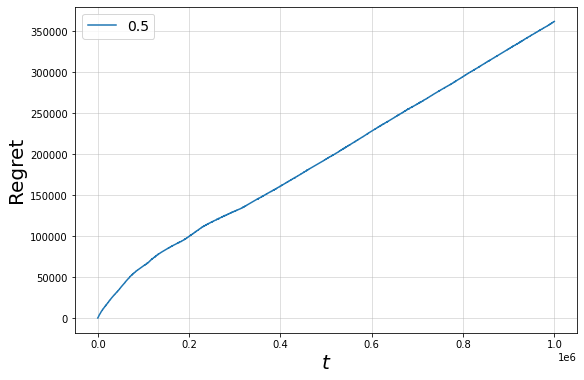

In [ ]:
#try:
#    regret_reward = np.load('/content/scores/regret_reward.npy',allow_pickle=True).item()
#except FileNotFoundError:
#    regret_reward = {}
    
a\

horizon_plot = -1
fig = plt.figure(1,figsize=(9,6))
for alpha in alpha_list:
    plt.plot(regret_reward[str(round(alpha,2))][0][:horizon_plot], label=str(alpha))
plt.xlabel('$t$', fontsize=20)
plt.ylabel('Regret', fontsize=20)
plt.legend(fontsize=14)
plt.grid(alpha=0.5)

In [ ]:
means

array([], shape=(0, 19), dtype=float64)

In [ ]:
T = 2000000

alpha_list = np.array([ 0.5])
#means = np.random.random((M, K))

#normalized means
means = np.divide(mean , 5.0)
means = means[150:160]
means.shape



n_simu = 10

print(means.shape)

(10, 20)


In [ ]:
mean.shape

(2113, 20)

In [ ]:
#client 
import numpy as np

class client(object):
    def __init__(self,
                 index,
                 thorizon,
                 narms,
                 nclients,
                 palpha,
                 fp):
        self.T = thorizon
        self.id = index
        self.K = narms
        self.M = nclients
        self.alpha = palpha
        self.fp = fp
        
        self.p = 1
        self.local_set = set(np.arange(self.K))
        self.global_set = set(np.arange(self.K))
        self.local_mean = np.zeros(self.K)
        self.global_mean = np.zeros(self.K)
        self.mixed_mean = np.zeros(self.K)
        self.reward = np.zeros(self.K)
        
        self.pull = np.zeros(self.K)
        self.p_length = self.fp(self.p)
        self.Fp = 0
        
        self.fphase = 0
        self.gphase = 0
        
        self.F = -1
        self.l_exploration = False
        self.g_exploration = False
    
    def play(self):
        if self.fphase < np.ceil((1-self.alpha)*self.p_length)*len(self.global_set): #global exploration
#            print("loc", self.p)
            #play = list(self.global_set)[self.fphase%len(self.global_set)]
            play = list(self.global_set)[int(self.fphase//(np.ceil((1-self.alpha)*self.p_length)))]
            self.fphase += 1
            
        elif self.gphase < np.ceil(self.M*self.alpha*self.p_length)*len(self.local_set): #local exploration
#            print("glob", self.p)
            #play = list(self.local_set)[self.gphase%len(self.local_set)]
            play = list(self.local_set)[int(self.gphase//(np.ceil(self.M*self.alpha*self.p_length)))]
            self.gphase += 1
            
        else: #exploitation phase
            if self.l_exploration is True:
                play = self.F
            else:
                play = np.argmax(self.alpha*self.local_mean+(1-self.alpha)*self.global_mean)
            
        return play
    
    def reward_update(self,play,obs):
        self.reward[play] += obs
        self.pull[play] += 1
        
    def local_mean_update(self):
        #print('global',self.fphase,np.ceil((1-self.alpha)*self.p_length)*len(self.global_set))
        #print('local',self.gphase,np.ceil(self.M*self.alpha*self.p_length)*len(self.local_set))
        if self.g_exploration is False and self.fphase >= np.ceil((1-self.alpha)*self.p_length)*len(self.global_set) and self.gphase >= np.ceil(self.M*self.alpha*self.p_length)*len(self.local_set):
            self.local_mean = self.reward/self.pull
            #print("local_mean",self.local_mean, "phase", self.p)
            return True, self.local_mean
        else:
            return False, 0
        
    def global_mean_update(self,global_stat):
        self.global_mean = global_stat
        self.mixed_mean = self.alpha*self.local_mean+(1-self.alpha)*self.global_mean
        
    def local_set_update(self):
        Ep = set()
        self.Fp += self.p_length
        conf_bound = np.sqrt(np.log(self.T)/(self.M*self.Fp))
        for i in list(self.local_set):
            if self.mixed_mean[i]+conf_bound < max(self.mixed_mean-conf_bound):
                Ep.add(i)
        self.local_set = self.local_set-Ep
        
        if len(self.local_set) == 1 and self.l_exploration is False:
            self.l_exploration = True
            self.F = list(self.local_set)[0]
            #print("player", self.id,  " fixate",self.F)
            self.local_set = set()
        #print("player", self.id, " local-set:",self.local_set)    
        return self.local_set
        
        
    def global_set_update(self,global_set):
        self.global_set = global_set
        self.p +=1
        self.p_length = self.fp(self.p)
        #print("p-length",self.p_length)
        self.fphase = 0
        self.gphase = 0
        self.g_exploration = (len(self.global_set)==0)
        
            
            
    
            

In [ ]:
#server

import numpy as np

class server(object):
    def __init__(self,
                 narms,
                 nclients):
        self.M = nclients
        self.K = narms
        
        self.local_means = np.zeros([self.M,self.K])
        self.global_means = np.zeros(self.K)
        self.global_set = set()
        self.p = 1
        self.c_local_stat = np.zeros(self.M)
        
    def local_mean_update(self,i,local_stat):
        self.local_means[i] = local_stat
        self.c_local_stat[i] = 1
        
    def global_mean_update(self):
        self.global_set = set()
        if sum(self.c_local_stat) >= self.M:
            self.global_means = np.sum(self.local_means, axis=0)/self.M
            self.c_local_stat = np.zeros(self.M)
            return True, self.global_means
        else:
            return False, 0
        
    def local_set_update(self,i,local_set):
        self.global_set = self.global_set|local_set
    
    def global_set_update(self):
        return self.global_set

In [ ]:
def fp(p):
    return 2**p*np.log(T)

In [ ]:
#bandits
class PFEDUCB(object):
    def __init__(self,
                 fun_fp,
                 T,
                 means, # M*K
                 alpha,
                 reward='Gaussian'):
        self.M = means.shape[0]
        self.K = means.shape[1]
        self.local_means = means
        self.reward_type = reward
        self.alpha = alpha
        self.T = T
        self.C = 1
        self.comm = 0
        
        self.global_means = np.sum(self.local_means, axis=0)/self.M
        self.clients = [
            client(index = i, thorizon = self.T, narms=self.K, nclients = self.M, palpha = self.alpha, fp=fun_fp) for i in range(self.M)
        ]
        self.server = server(narms=self.K, nclients = self.M)


    def simulate_single_step_rewards(self):
        if self.reward_type == 'Bernoulli':
            return np.random.binomial(1, self.local_means)
        return np.random.normal(self.local_means, 1)

    def simulate_single_step(self, plays):

        local_rews = self.simulate_single_step_rewards()
        global_rews = np.mean(local_rews,axis=0)
        
        local_rewards = np.array([local_rews[i,plays[i]] for i in range(self.M)])
        global_rewards = np.array([global_rews[plays[i]] for i in range(self.M)])
        mixed_rewards = self.alpha*local_rewards+(1-self.alpha)*global_rewards
        #rewards = np.array([self.alpha*local_rews[i,plays[i]]+(1-self.alpha)*global_rews[plays[i]] for i in range(self.M)])

        return local_rewards, global_rewards, mixed_rewards

    def simulate(self):
        """
        Return the vector of regret for each time step until horizon
        """

        local_rewards = []
        global_rewards = []
        mixed_rewards = []
        
        play_history = []
           

        for t in range(self.T):
            plays = np.zeros(self.M)
            
            plays = [(int)(client.play()) for client in self.clients]
            local_rews, global_rews, mixed_rews = self.simulate_single_step(plays)
            #obs, rews = self.simulate_single_step(plays)  # observations of all players
            
            local_rewards.append(np.sum(local_rews))
            global_rewards.append(np.sum(global_rews))
            mixed_rewards.append(np.sum(mixed_rews))
            play_history.append(plays)
            
            #print(plays)
            
            for i in range(self.M):
                self.clients[i].reward_update(plays[i], local_rews[i])  # update strategies of all player

            for i in range(self.M):
                f_local_stat, local_stat = self.clients[i].local_mean_update()
                if f_local_stat is True:
                    self.server.local_mean_update(i,local_stat)
                f_local_stat = False
                    
            f_global_stat, global_stat = self.server.global_mean_update()
            
            if f_global_stat is True:
                for i in range(self.M):
                    self.clients[i].global_mean_update(global_stat)
                    local_set = self.clients[i].local_set_update()
                    self.server.local_set_update(i,local_set)
                
                global_set = self.server.global_set_update()
                #print(t," global-set:",global_set)
                for i in range(self.M):
                    self.clients[i].global_set_update(global_set)
                    local_rewards[-1] -= 2*self.C
                    global_rewards[-1] -= 2*self.C
                    mixed_rewards[-1] -= 2*self.C
                    self.comm += 2*self.C
                    #print(t,"comm")
                f_global_stat = False
            
        top_mixed_means = np.zeros(self.M)
        
          top_arms = np.zeros(self.M, dtype=int)
          sub_gap = np.zeros(self.M)
        for i in range(self.M):
            top_arms[i] = np.argmax(self.alpha*self.local_means[i]+(1-self.alpha)*self.global_means)
            top_mixed_means[i] = self.alpha*self.local_means[i][top_arms[i]]+(1-self.alpha)*self.global_means[top_arms[i]]
            sub_gap[i] = np.sort(self.alpha*self.local_means[i]+(1-self.alpha)*self.global_means)[-2]-top_mixed_means[i]
            #print("player", i, " top_arm:",top_arms[i], " top_mean:", top_mixed_means[i], " gap:", sub_gap[i])
        
        best_case_reward = np.sum(top_mixed_means) * np.arange(1, self.T + 1)
        
        cumulated_local_reward = np.cumsum(local_rewards)
        cumulated_global_reward = np.cumsum(global_rewards)
        cumulated_mixed_reward = np.cumsum(mixed_rewards)

        regret = best_case_reward - cumulated_mixed_reward
#        print(cumulated_mixed_reward)
#        print(best_case_reward)
#        print('regret:',regret[-1], "comm: ", self.comm)
        self.regret = (regret, best_case_reward, cumulated_mixed_reward)
        self.top_mixed_means = top_mixed_means
        return regret, cumulated_local_reward, cumulated_global_reward, cumulated_mixed_reward

    def get_clients(self):
        return self.clients

IndentationError: ignored

In [ ]:
# try to load for a warm restart
try:
    regret_reward = np.load('/content/scores/regret_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}
    
try:  
    raw_regret = np.load('/content/scores/raw_regret.npy',allow_pickle=True).item()
except FileNotFoundError:
    raw_regret = {}
    
try:  
    local_reward = np.load('/content/scores/local_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    local_reward = {}
    
try:  
    global_reward = np.load('/content/scores/global_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    global_reward = {}
    
try:  
    mixed_reward = np.load('/content/scores/mixed_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    mixed_reward = {}

In [ ]:
try:
    for alpha in alpha_list:
        try:
            # the number of runs to run for this algo
            nalgo = n_simu-len(raw_regret[str(round(alpha,2))])
        except KeyError:
            # case of algo not loaded (ie 0 run already done)
            raw_regret[str(round(alpha,2))] = []
            local_reward[str(round(alpha,2))] = []
            global_reward[str(round(alpha,2))] = []
            mixed_reward[str(round(alpha,2))] = []
            nalgo = n_simu

        for i in tqdm.tqdm(range(nalgo), desc="Simulating {}".format("P-Fed-UCB, alpha:"+str(alpha))):
            pfed = PFEDUCB(fp, T, means, alpha) # simulate a run with the chosen parameters
            mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1 = pfed.simulate()
            raw_regret[str(round(alpha,2))].append(mixed_regret_1)  
            local_reward[str(round(alpha,2))].append(local_reward_1)
            global_reward[str(round(alpha,2))].append(global_reward_1)
            mixed_reward[str(round(alpha,2))].append(mixed_reward_1)
            
            regret_reward[str(round(alpha,2))] = [np.mean(raw_regret[str(round(alpha,2))], axis=0),
                                np.std(raw_regret[str(round(alpha,2))], axis=0),
                                np.min(raw_regret[str(round(alpha,2))], axis=0),
                                np.max(raw_regret[str(round(alpha,2))], axis=0),
                                np.mean(local_reward[str(round(alpha,2))], axis=0),
                                np.mean(global_reward[str(round(alpha,2))], axis=0),
                                np.mean(mixed_reward[str(round(alpha,2))], axis=0)]
            
            del mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1   
except KeyboardInterrupt:
    # save in case of interruption
    print('alpha:', alpha, 'Number of tries ran: ', len(raw_regret[str(round(alpha,2))]))
    np.save('scores/raw_regret.npy', raw_regret)
    np.save('scores/local_reward.npy',local_reward)
    np.save('scores/global_reward.npy',global_reward)
    np.save('scores/mixed_reward.npy',mixed_reward)
    np.save('scores/regret_reward.npy', regret_reward)
    del raw_regret, local_reward, global_reward, regret_reward


Simulating P-Fed-UCB, alpha:0.5: 100%|██████████| 10/10 [1:30:59<00:00, 545.97s/it]


In [ ]:
regret_reward

{'0.5': [array([1.61508038e+00, 5.60906376e+00, 7.33952524e+00, ...,
         2.24869362e+05, 2.24868615e+05, 2.24867148e+05]),
  array([2.20041112e+00, 2.66430943e+00, 3.47494852e+00, ...,
         9.57674173e+03, 9.57709537e+03, 9.57507749e+03]),
  array([-2.86439211e+00, -2.34114769e-01,  1.05591278e+00, ...,
          2.08365361e+05,  2.08364601e+05,  2.08366857e+05]),
  array([5.52265971e+00, 1.00579205e+01, 1.24976780e+01, ...,
         2.37312693e+05, 2.37314785e+05, 2.37313398e+05]),
  array([6.49233055e+00, 1.06057581e+01, 1.69827075e+01, ...,
         1.63777656e+07, 1.63777751e+07, 1.63777849e+07]),
  array([6.49233055e+00, 1.06057581e+01, 1.69827075e+01, ...,
         1.56021070e+07, 1.56021151e+07, 1.56021245e+07]),
  array([6.49233055e+00, 1.06057581e+01, 1.69827075e+01, ...,
         1.59899363e+07, 1.59899451e+07, 1.59899547e+07])]}

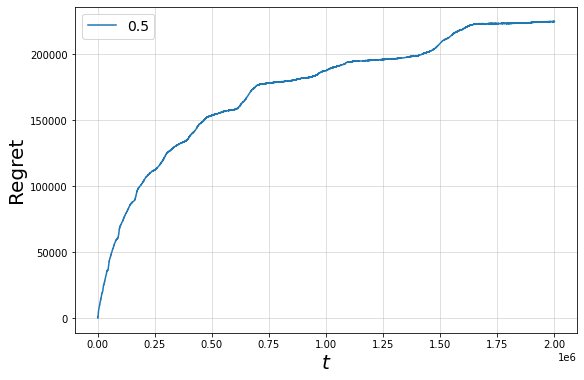

In [ ]:
#try:
#    regret_reward = np.load('/content/scores/regret_reward.npy',allow_pickle=True).item()
#except FileNotFoundError:
#    regret_reward = {}
    
horizon_plot = -1
fig = plt.figure(1,figsize=(9,6))
for alpha in alpha_list:
    plt.plot(regret_reward[str(round(alpha,2))][0][:horizon_plot], label=str(alpha))
plt.xlabel('$t$', fontsize=20)
plt.ylabel('Regret', fontsize=20)
plt.legend(fontsize=14)
plt.grid(alpha=0.5)

In [ ]:
# try to load for a warm restart
try:
    regret_reward = np.load('/content/scores/regret_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    regret_reward = {}
    
try:  
    raw_regret = np.load('/content/scores/raw_regret.npy',allow_pickle=True).item()
except FileNotFoundError:
    raw_regret = {}
    
try:  
    local_reward = np.load('/content/scores/local_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    local_reward = {}
    
try:  
    global_reward = np.load('/content/scores/global_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    global_reward = {}
    
try:  
    mixed_reward = np.load('/content/scores/mixed_reward.npy',allow_pickle=True).item()
except FileNotFoundError:
    mixed_reward = {}

In [ ]:
try:
    for alpha in alpha_list:
        try:
            # the number of runs to run for this algo
            nalgo = n_simu-len(raw_regret[str(round(alpha,2))])
        except KeyError:
            # case of algo not loaded (ie 0 run already done)
            raw_regret[str(round(alpha,2))] = []
            local_reward[str(round(alpha,2))] = []
            global_reward[str(round(alpha,2))] = []
            mixed_reward[str(round(alpha,2))] = []
            nalgo = n_simu

        for i in tqdm.tqdm(range(nalgo), desc="Simulating {}".format("P-Fed-UCB, alpha:"+str(alpha))):
            pfed = PFEDUCB(fp, T, means, alpha, prob = 0.5) # simulate a run with the chosen parameters
            mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1 = pfed.simulate()
            raw_regret[str(round(alpha,2))].append(mixed_regret_1)  
            local_reward[str(round(alpha,2))].append(local_reward_1)
            global_reward[str(round(alpha,2))].append(global_reward_1)
            mixed_reward[str(round(alpha,2))].append(mixed_reward_1)
            
            regret_reward[str(round(alpha,2))] = [np.mean(raw_regret[str(round(alpha,2))], axis=0),
                                np.std(raw_regret[str(round(alpha,2))], axis=0),
                                np.min(raw_regret[str(round(alpha,2))], axis=0),
                                np.max(raw_regret[str(round(alpha,2))], axis=0),
                                np.mean(local_reward[str(round(alpha,2))], axis=0),
                                np.mean(global_reward[str(round(alpha,2))], axis=0),
                                np.mean(mixed_reward[str(round(alpha,2))], axis=0)]
            
            #del mixed_regret_1, local_reward_1, global_reward_1, mixed_reward_1



    
except KeyboardInterrupt:
    # save in case of interruption
    print('alpha:', alpha, 'Number of tries ran: ', len(raw_regret[str(round(alpha,2))]))
    np.save('scores/raw_regret.npy', raw_regret)
    np.save('scores/local_reward.npy',local_reward)
    np.save('scores/global_reward.npy',global_reward)
    np.save('scores/mixed_reward.npy',mixed_reward)
    np.save('scores/regret_reward.npy', regret_reward)
    del raw_regret, local_reward, global_reward, regret_reward



Simulating P-Fed-UCB, alpha:0.5:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


player 0  top_arm: 4  top_mean: 0.7166666666666667  gap: -0.050000000000000044
player 1  top_arm: 5  top_mean: 0.7166666666666667  gap: -0.050000000000000044
player 2  top_arm: 7  top_mean: 0.7083333333333333  gap: -0.04166666666666663




Simulating P-Fed-UCB, alpha:0.5:  10%|█         | 1/10 [02:04<18:38, 124.24s/it]

player 0  top_arm: 1  top_mean: 0.75  gap: 0.0
player 1  top_arm: 3  top_mean: 0.75  gap: 0.0




Simulating P-Fed-UCB, alpha:0.5:  20%|██        | 2/10 [04:08<16:32, 124.10s/it]

player 0  top_arm: 1  top_mean: 0.75  gap: 0.0
player 1  top_arm: 3  top_mean: 0.75  gap: 0.0




Simulating P-Fed-UCB, alpha:0.5:  30%|███       | 3/10 [06:11<14:27, 123.94s/it]

player 0  top_arm: 5  top_mean: 0.7083333333333334  gap: -0.04166666666666674
player 1  top_arm: 6  top_mean: 0.7166666666666667  gap: -0.050000000000000044
player 2  top_arm: 7  top_mean: 0.7  gap: -0.033333333333333326




Simulating P-Fed-UCB, alpha:0.5:  40%|████      | 4/10 [08:15<12:23, 123.99s/it]

player 0  top_arm: 2  top_mean: 1.0  gap: -0.09999999999999998




Simulating P-Fed-UCB, alpha:0.5:  50%|█████     | 5/10 [10:19<10:19, 123.90s/it]

player 0  top_arm: 4  top_mean: 0.7625  gap: -0.012499999999999956
player 1  top_arm: 6  top_mean: 0.7625  gap: -0.012499999999999956




Simulating P-Fed-UCB, alpha:0.5:  60%|██████    | 6/10 [12:22<08:15, 123.79s/it]

player 0  top_arm: 4  top_mean: 0.7166666666666667  gap: -0.050000000000000044
player 1  top_arm: 5  top_mean: 0.7166666666666667  gap: -0.050000000000000044
player 2  top_arm: 7  top_mean: 0.7083333333333333  gap: -0.04166666666666663




Simulating P-Fed-UCB, alpha:0.5:  70%|███████   | 7/10 [14:26<06:11, 123.84s/it]

player 0  top_arm: 4  top_mean: 0.775  gap: -0.025000000000000022
player 1  top_arm: 7  top_mean: 0.7625  gap: -0.012499999999999956




Simulating P-Fed-UCB, alpha:0.5:  80%|████████  | 8/10 [16:31<04:07, 123.94s/it]

player 0  top_arm: 4  top_mean: 0.7083333333333333  gap: -0.04166666666666663
player 1  top_arm: 5  top_mean: 0.725  gap: -0.05833333333333335
player 2  top_arm: 6  top_mean: 0.7166666666666667  gap: -0.050000000000000044




Simulating P-Fed-UCB, alpha:0.5:  90%|█████████ | 9/10 [18:34<02:03, 123.74s/it]

player 0  top_arm: 4  top_mean: 0.7166666666666667  gap: -0.050000000000000044
player 1  top_arm: 5  top_mean: 0.7166666666666667  gap: -0.050000000000000044
player 2  top_arm: 7  top_mean: 0.7083333333333333  gap: -0.04166666666666663




Simulating P-Fed-UCB, alpha:0.5: 100%|██████████| 10/10 [20:38<00:00, 123.89s/it]


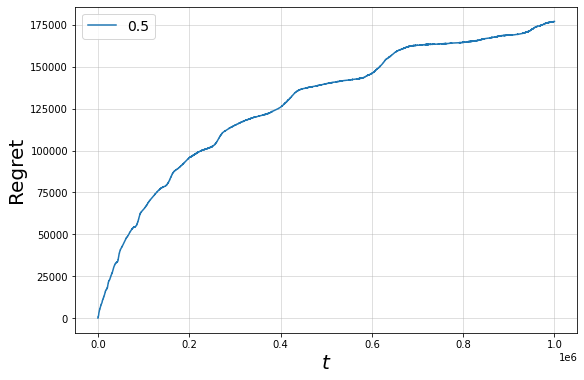

In [ ]:
#try:
#    regret_reward = np.load('/content/scores/regret_reward.npy',allow_pickle=True).item()
#except FileNotFoundError:
#    regret_reward = {}
    

horizon_plot = -1
fig = plt.figure(1,figsize=(9,6))
for alpha in alpha_list:
    plt.plot(regret_reward[str(round(alpha,2))][0][:horizon_plot], label=str(alpha))
plt.xlabel('$t$', fontsize=20)
plt.ylabel('Regret', fontsize=20)
plt.legend(fontsize=14)
plt.grid(alpha=0.5)